In [1]:
import NotebookImport
import DX_screen as DX

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [3]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
MESO


In [4]:
cancers = codes.ix[matched_tn.columns.get_level_values(0)].unique()
pts = matched_tn.columns.get_level_values(0)
cancers_to_use = ti(codes.ix[pts].value_counts() > 15)

df_inf = {c: infer_normal_knn(rna_df.ix[:, ti(codes == c)], r_curtoff=.3, k=5)
          for c in cancers_to_use}
tn_inf_c = pd.concat(df_inf.values(), axis=1)

In [5]:
f = DX.dx_rna.frac
fm = f

In [6]:
fm.shape

(18419,)

In [7]:
store = pd.HDFStore('/data_ssd/RNASeq_2015_02_04.h5')

In [10]:
pts = [p for p in tn_inf_c.columns.get_level_values(0) if 
       (p,'01') in tn_inf_c.columns and (p,'11') in DX.rna_df.columns]
pts = list(set(pts))

In [11]:
mm = DX.rna_df.xs('11',1,1).ix[:, pts].mean(1).ix[fm.index]
ss = DX.rna_df.xs('11',1,1).ix[:, pts].std(1).ix[fm.index]

In [12]:
fm.shape

(18419,)

In [13]:
df = tn_inf_c
df = df.sub(mm, axis=0).div(ss, axis=0)
rna_s = df.corrwith(fm - .5)

In [14]:
#rp.to_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv')

In [16]:
rp = rna_s

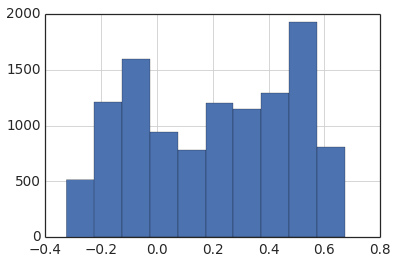

In [17]:
rp.hist()

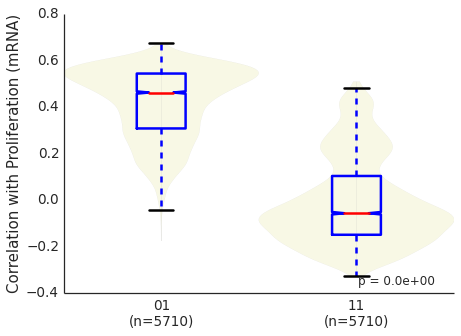

In [18]:
fig, ax = subplots(figsize=(7,5))
violin_plot_series(rp, ax=ax, order=['01','11'])
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
prettify_ax(ax)

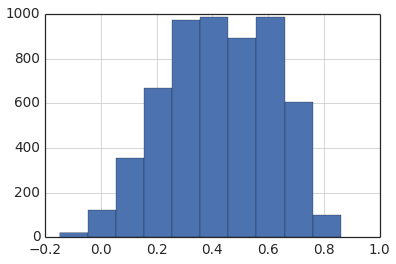

In [19]:
(rp[:, '01'] - rp[:, '11']).hist()

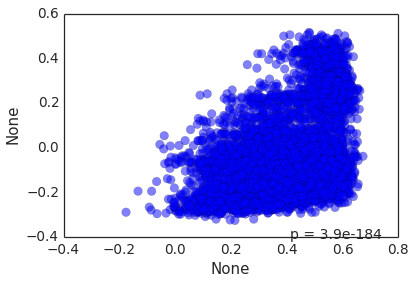

In [20]:
series_scatter(rp[:, '01'], rp[:, '11'])

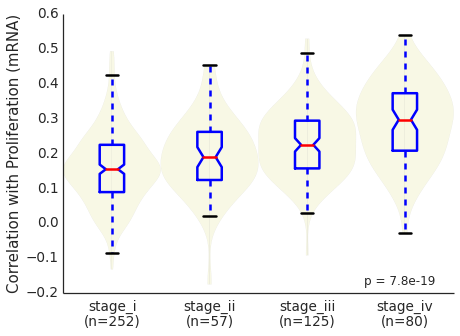

In [21]:
fig, ax = subplots(figsize=(7,5))
violin_plot_pandas(stage.ix[ti(codes=='KIRC')], rp[:,'01'], ax=ax, 
                   order=['stage_i','stage_ii','stage_iii','stage_iv'])
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
prettify_ax(ax)

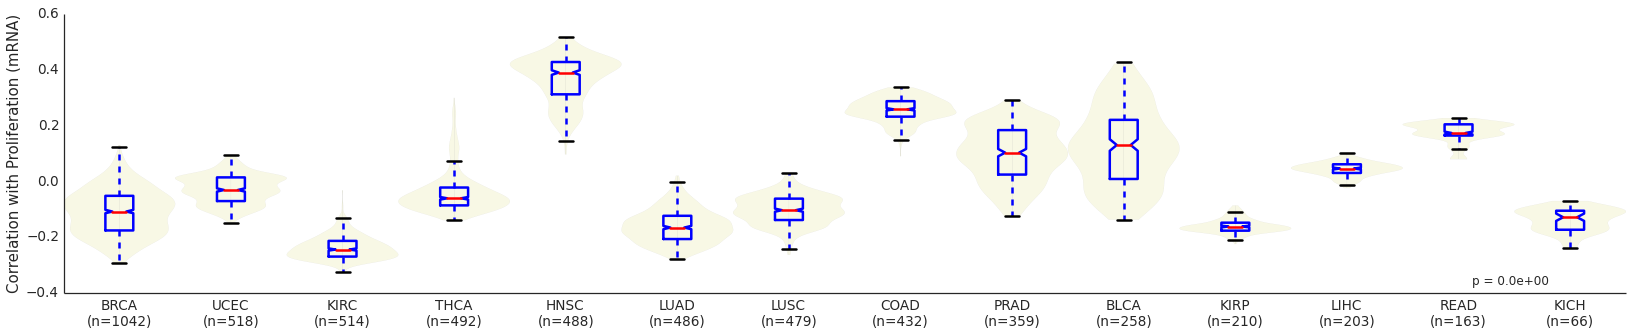

In [22]:
fig, ax = subplots(figsize=(28,5))
violin_plot_pandas(DX.codes, rp[:,'11'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation with Proliferation (mRNA)')
prettify_ax(ax)

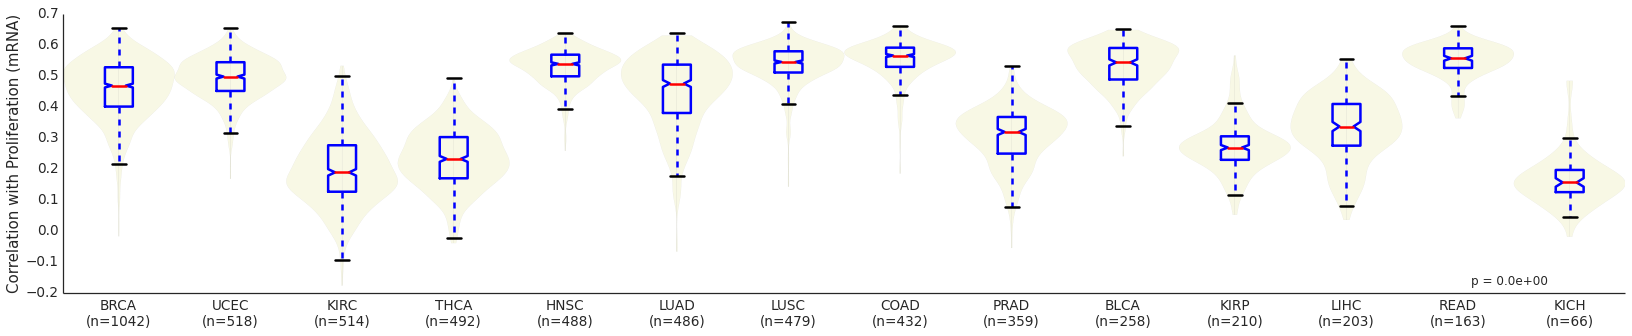

In [23]:
fig, ax = subplots(figsize=(28,5))
violin_plot_pandas(codes, rp[:,'01'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation with Proliferation (mRNA)')
prettify_ax(ax)

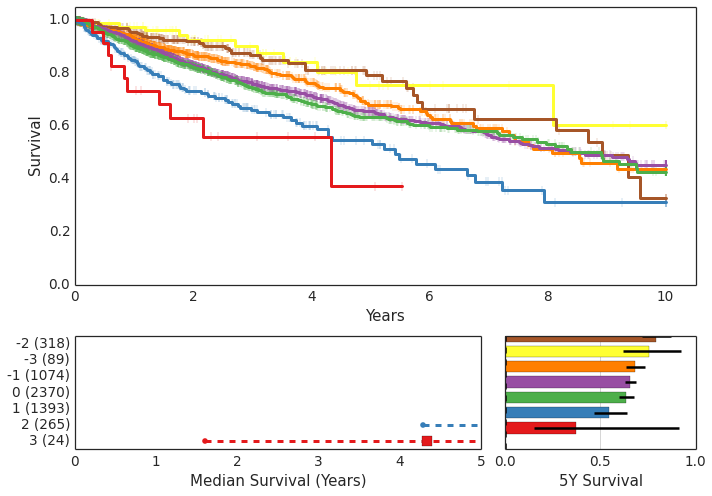

In [25]:
v = (rp[:, '01']  - rp.ix[:, '11']).dropna()
v = v - codes.map(v.groupby(codes).median())
survival_and_stats(np.round((v - v.mean()) / v.std()).clip(-3,3), surv_10y,
                   figsize=(10,7))

In [26]:
def plot_HR(ci, colors=None, ax=None):
    _, ax = init_ax(ax)
    if colors is None:
        colors = ['grey'] * ci.shape[0]
    ci = np.log2(ci)
    for i,(h,v) in enumerate(ci.iterrows()):
        ax.scatter(v['exp(coef)'], i, marker='s', s=100, color=colors[i], 
                   edgecolors=['black'], zorder=10)
        ax.plot((v['lower .95'],v['upper .95']), (i,i), 
                    lw=3, ls='-', marker='o', dash_joinstyle='bevel', 
                color=colors[i])
    prettify_ax(ax)
    ax.set_ybound(-.5, i + .5)
    ax.set_yticks(range(i+1))
    ax.set_yticklabels(ci.index)
    ax.axvline(0, ls='--', lw=2, color='grey', zorder=-1)
    ax.set_xticklabels(2.**ax.get_xticks())

In [27]:
f = (rp[:, '01']  - rp.ix[:, '11']).dropna()
f = (f - f.mean()) / f.std()
m = get_cox_ph(surv_5y, f, [codes, stage, old, age], print_desc=False, interactions=False)
ci = convert_robj(robjects.r.summary(m)[7])
pancan_ci = ci.ix['feature']
pancan_ci.name = 'PANCAN'

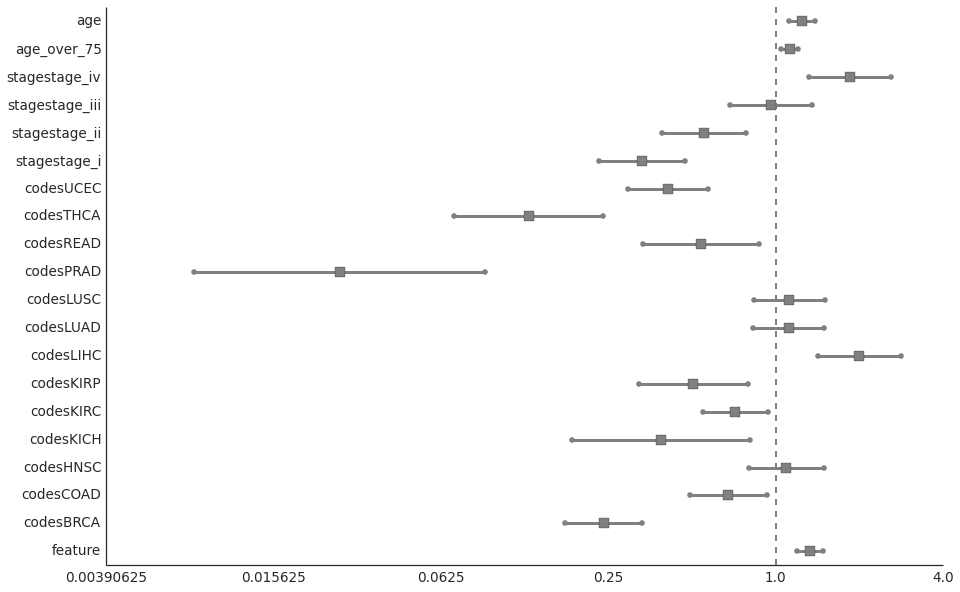

In [28]:
fig, ax = subplots(figsize=(15,10))
plot_HR(ci, ax=ax)

In [32]:
v = (rp[:, '01']  - rp.ix[:, '11']).dropna()
ci = {}
for c in codes.unique():
    try:
        pts = ti(codes == c)
        f = v.ix[pts].dropna()
        cov = [b.ix[pts].dropna() for b in [stage, old, age] if 
               b.ix[pts].dropna().unique().shape[0] > 1]
        f = (f - f.mean()) / f.std()
        m1 = get_cox_ph(surv_5y, f, covariates=cov, 
                        print_desc=False, interactions=False);
        ci[c] = convert_robj(robjects.r.summary(m1)[7])
    except:
        print c

In [33]:
cc = pd.concat(ci).xs('feature', level=1)
cc = cc.sort('exp(coef)', ascending=False)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 100]

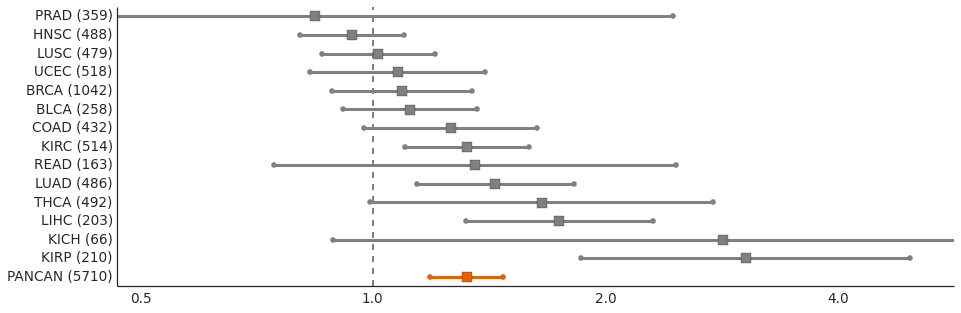

In [35]:
fig, ax = subplots(figsize=(15,5))
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label);

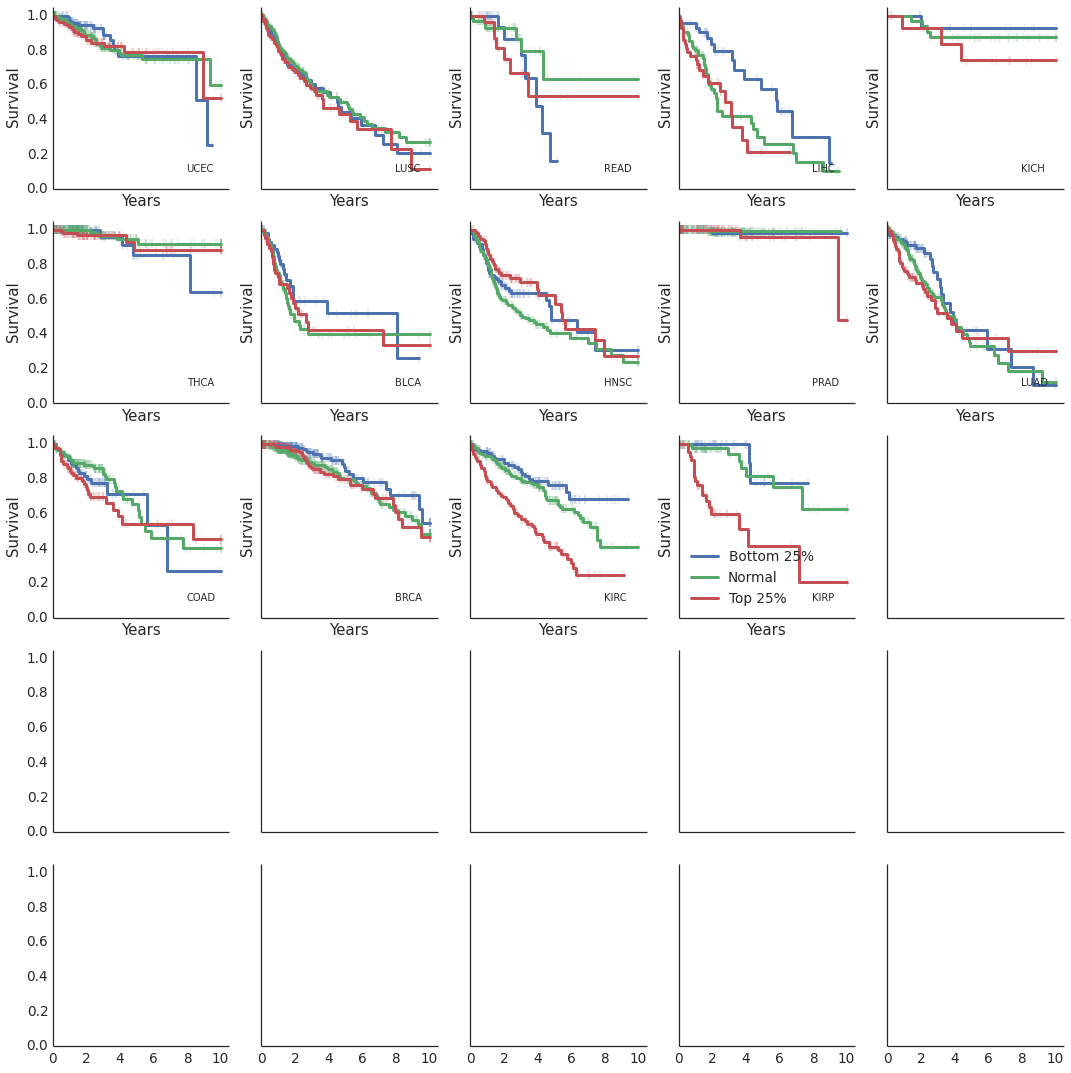

In [36]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,5, figsize=(15,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    draw_survival_curve(v.ix[ss].ix[ti(cc==c)].dropna(), surv_10y,
                        ax=ax)
    ax.legend_.set_visible(False)
ax.legend_.set_visible(True)
fig.tight_layout()
DX.sns.despine(fig)

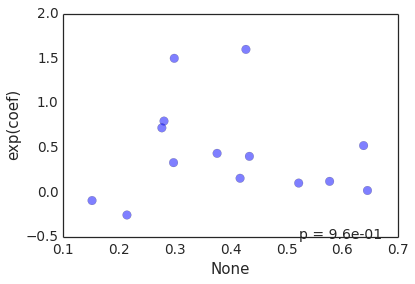

In [38]:
cc = pd.concat(ci).xs('feature', level=1)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 100]
v = (rp[:, '01']  - rp.ix[:, '11']).dropna()
series_scatter(v.groupby(codes).median(), np.log2(cc['exp(coef)']))

In [47]:
v = (rp[:, '01']).dropna()
#v = v - codes.map(v.groupby(codes).median())
v = v.dropna()
v.name = 'f'

In [48]:
get_cox_ph_ms(surv_5y, v, [codes, stage, old], interactions=False)

LR                                                    1.98e-15
feature_p                                             1.02e-14
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   21.8
dtype: object

In [49]:
get_cox_ph_ms(surv_5y, v, [codes, old], interactions=False)

LR                                                     6.7e-25
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + age_over...
hazzard                                                   52.4
dtype: object

In [50]:
get_cox_ph_ms(surv_5y, v.ix[keepers], [codes, stage, old, age], interactions=False)

LR                                                    8.91e-11
feature_p                                             3.02e-10
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   18.1
dtype: object